# MSDS 7331 - Case Study 3 - Clasification of e-mail as ham or spam
Daniel Crouthamel

Sophia Wu

Fabio Savorgnan

Bo Yun

# Introduction

In this study, we will be building a classifier to predict busines that will go on bankrupcy. 

# Business Understanding

You should always state the objective at the beginning of every case (a guideline you should follow in real life as well) and provide some initial "Business Understanding" statements (i.e., what is trying to be solved for and why might it be important)

In [2]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy.stats import randint as sp_randint

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

#Pipeline
from sklearn.pipeline import make_pipeline

# Files
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
from scipy.io import arff



# Data engeniering

Summarize the data being used in the case using appropriate mediums (charts, graphs, tables); address questions such as: Are there missing values? Which variables are needed (which ones are not)? What assumptions or conclusions are you drawing that need to be relayed to your audience?

## Load the data and EDA

In [3]:
files = ['data/1year.arff', 'data/2year.arff', 'data/3year.arff', 'data/4year.arff', 'data/5year.arff']


df = pd.DataFrame(arff.loadarff(files[0])[0])

for f in files[1:]:
    data_temp = arff.loadarff(f)
    df_temp = pd.DataFrame(data_temp[0])
    print(df_temp.shape)
    df = df.merge(df_temp,how='outer') 

(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [4]:
print(df.shape)

df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


## Evaluate and transform to binary 0 0r 1 the target

In [5]:
df["class"].unique


<bound method Series.unique of 0        b'0'
1        b'0'
2        b'0'
3        b'0'
4        b'0'
         ... 
43400    b'1'
43401    b'1'
43402    b'1'
43403    b'1'
43404    b'1'
Name: class, Length: 43405, dtype: object>

In [6]:
# This show that the target is very inbalanced
df['class'].value_counts(normalize=False)

b'0'    41314
b'1'     2091
Name: class, dtype: int64

(array([41314.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2091.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

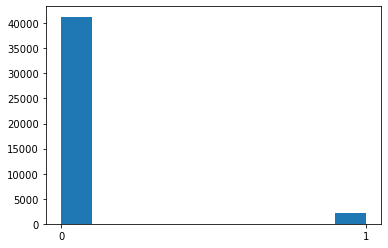

In [8]:
# Plot to better show the inbalanced target
plt.hist(df['class'])

In [9]:
# Convert the target in 0 an1

classes = []

for index, row in df.iterrows():
    class_val = row['class']
    if class_val not in classes:
        classes.append(class_val)

class_dict = {}

for index, i in enumerate(classes):
    class_dict.update({i:str(index)})
    
df['class'] = df['class'].map(class_dict)

df['class'].unique()

array(['0', '1'], dtype=object)

In [10]:
# Dataframe
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


## Explore the differents columns of the data with pandas profiling

In [11]:
pip install pandas_profiling

  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)
     |████████████████████████████████| 2.6 MB 3.6 MB/s 
     |████████████████████████████████| 653 kB 7.3 MB/s 
  Using cached multimethod-1.6-py3-none-any.whl (9.4 kB)
  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached tangled_up_in_unicode-0.1.0-py3-none-any.whl (3.1 MB)
  Using cached visions-0.7.4-py3-none-any.whl (102 kB)
  Using cached ImageHash-4.2.1.tar.gz (812 kB)
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=4af20204bc95d5924d87e0ba9346a159072c69d3f99562a416e06f5fee3837d9
  Stored in directory: /Users/boyun/Library/Caches/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=1b65679285308c685b24e7bae21926b1fc32df17cabb922c581fb2265caf36e2
  Stored in directory: /Users/boyun/Library/Caches/p

In [13]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="Bo_output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 94.37it/s]


We decided that missing values less than 10 % we bould keep as variables for our model because we would impute with the meam for the missing values. We will use the simple imputer.

So we decided to take out the Attr 21  "Sales (n) / sales (n-1)" because it has 13.5 missing values, also we decide to take out Attr 37 "Profit on operating activities / financial expenses" because it has 43.7 missing values. We believe specially for Attr 37 that this amount of missing values would not be able to replace in a meaninfull way with imputation.

We also plan to normalize the data using the rubost scaler.

Please see the attached pandas profiles.
  


(array([3.7541e+04, 4.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-1325. ,  1798.2,  4921.4,  8044.6, 11167.8, 14291. , 17414.2,
        20537.4, 23660.6, 26783.8, 29907. ]),
 <BarContainer object of 10 artists>)

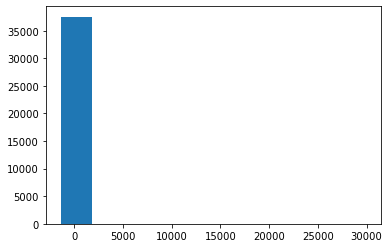

In [12]:
# Sales (n) / sales (n-1)
plt.hist(df["Attr21"])

(array([2.4411e+04, 5.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  -525.52 ,  39419.032,  79363.584, 119308.136, 159252.688,
        199197.24 , 239141.792, 279086.344, 319030.896, 358975.448,
        398920.   ]),
 <BarContainer object of 10 artists>)

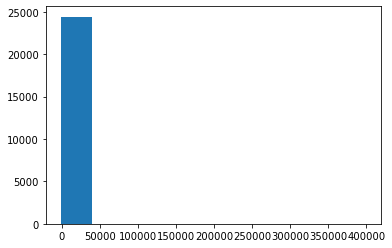

In [13]:
# Profit on operating activities / financial expenses
plt.hist(df["Attr37"])

In [14]:
# Final dataframe
df= df.drop(["Attr21"], axis = 1)
df= df.drop(["Attr37"], axis = 1)
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


# Model preparation

Which methods are you proposing to utilize to solve the problem?  Why is this method appropriate given the business objective? How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a binary-classification one (ex., Accuracy, F1-score, Precision, Recall, AUC, etc.)?

## Randon Forest

In [75]:
# prepare test and train data

X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [76]:
# Impute

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test= transformer.transform(X_test)

# Model building and Evaluation

In this case, your primary task is to build both a Random Forest and XGBoost model to accurately predict bankruptcy and will involve the following steps:

- Specify your sampling methodology
- Setup your models - highlighting any important parameters
- Analyze each model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

## Set up the Grid Search for Random Forest

In [106]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


RandomizedSearchCV took 264.80 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.967 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.967 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.967 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_split': 8}

GridSearchCV took 674.90 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.969 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.969 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': N

## Evaluation of the model

In [107]:
y_hat_rf_train = grid_search.predict(X_train)
accuracy_score(y_hat_rf_train, y_train)

1.0

In [108]:
# Confusion matrix train
confusion_matrix(y_train, y_hat_rf_train)

array([[27711,     0],
       [    0,  1370]])

In [109]:
y_hat_rf_test = grid_search.predict(X_test)
accuracy_score(y_hat_rf_test, y_test)

0.9664898073163921

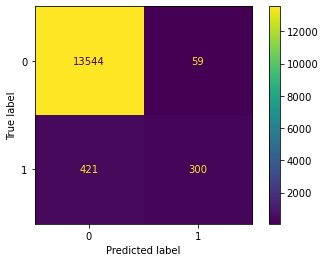

In [110]:
# Confusion matrix test
confusion_matrix(y_test, y_hat_rf_test)
disp = ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)

In [111]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_rf_test, pos_label="1", average='binary'))
print("Precision:", precision_score(y_test, y_hat_rf_test, pos_label="1", average='binary'))

Recall: 0.4160887656033287
Precision: 0.8356545961002786


## Plot evaluation

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

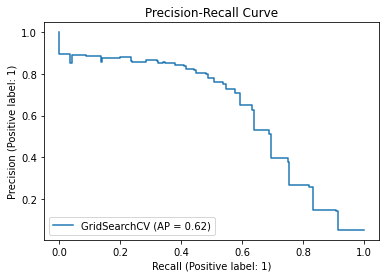

In [112]:
disp = plot_precision_recall_curve(grid_search, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

## ROC

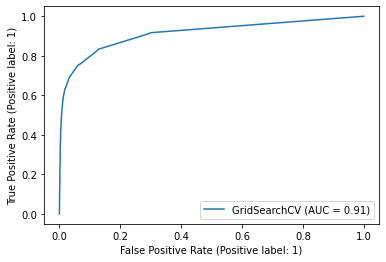

In [113]:
Disp = RocCurveDisplay.from_estimator(grid_search, X_test, y_test)

## GBoost model

In [95]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.1,
    max_depth=10, random_state=0).fit(X_train, y_train)

## Evaluation of the model for comparison to random forest, in order to see if we can improve the Random forest best model

In [96]:
clf.score(X_train, y_train)

1.0

In [97]:
clf.score(X_test, y_test)

0.9720748394303267

In [98]:
clf.feature_importances_

array([0.00338274, 0.00408363, 0.00719277, 0.01434777, 0.07687351,
       0.01513886, 0.0014729 , 0.00204911, 0.01970434, 0.00311262,
       0.00430253, 0.00275583, 0.00697153, 0.00163451, 0.00753192,
       0.01176732, 0.00298242, 0.00130664, 0.01684912, 0.00915844,
       0.00868015, 0.0026787 , 0.01963419, 0.01318094, 0.01720419,
       0.0607643 , 0.00380925, 0.01224736, 0.00928163, 0.00361718,
       0.00830058, 0.0065207 , 0.1884021 , 0.01329476, 0.00612435,
       0.00712094, 0.0178849 , 0.02072994, 0.00976115, 0.00840103,
       0.00759141, 0.03507556, 0.00711413, 0.04830225, 0.01388091,
       0.0116442 , 0.00728095, 0.00736592, 0.00357958, 0.00566391,
       0.00327336, 0.00707499, 0.01208388, 0.08066922, 0.00805318,
       0.02831713, 0.00451134, 0.01516966, 0.02524388, 0.00365963,
       0.00578885, 0.00839919])

In [99]:
y_hat_G = clf.predict(X_test)

In [100]:
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_G, pos_label="1", average='binary'))
print("Precision:", precision_score(y_test, y_hat_G, pos_label="1", average='binary'))

Recall: 0.5145631067961165
Precision: 0.8812351543942993


## Plot precision and recall

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall Curve')

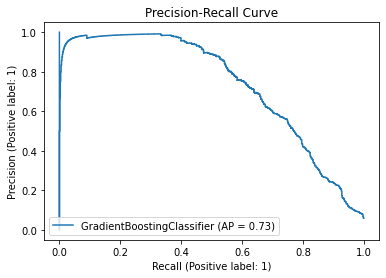

In [101]:
disp = plot_precision_recall_curve(clf, X_test, y_test,)
disp.ax_.set_title('Precision-Recall Curve')

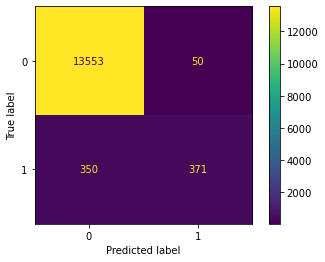

In [102]:
# Confusion matrix
confusion_matrix(y_test, y_hat_G)
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

## ROC 

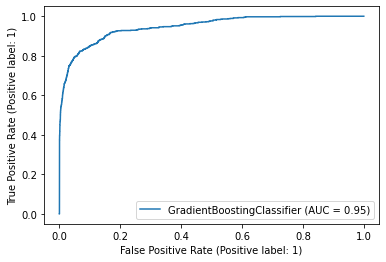

In [103]:
isp = RocCurveDisplay.from_estimator(clf, X_test, y_test)

## Try the grid search for GBoost in order to see if there is any improvement

In [104]:
param_test1 = {'n_estimators':range(100, 500, 1000),
'max_depth':range(10,16), 'min_samples_split':range(1, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,min_samples_leaf= 1,random_state= 0), 
param_grid = param_test1,n_jobs=4).fit(X_train, y_train)
gsearch1.score(X_test, y_test)

/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/Users/fabiosavorgnan/opt/anaconda3/envs/SMU/lib/python3.7/site-packages/sklearn/ensemble/_gb.py", line 

0.972144652331751

In [105]:
y_hat_GG = gsearch1.predict(X_test)
# Precision and recall
print("Recall:", recall_score(y_test, y_hat_GG, pos_label="1", average='binary'))
print("Precision:", precision_score(y_test, y_hat_GG, pos_label="1", average='binary'))

Recall: 0.5173370319001387
Precision: 0.8797169811320755


## XGBoost

In [21]:
# prepare test and train data

X = df.loc[:, df.columns != 'class'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [22]:
# Impute

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Normalize the data
transformer = RobustScaler().fit(X_train)
transformer = RobustScaler().fit(X_test)
X_train = transformer.transform(X_train)
X_test= transformer.transform(X_test)

In [42]:
y_pred.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U21')

In [23]:
# pip install xgboost
import xgboost as xgb

train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)


In [24]:
param = {'max_depth': 4, 'eta': 0.2, 'objective': 'multi:softmax', 'num_class': 2}
epochs = 10



In [27]:
model_xgb = xgb.train(param,train,epochs)

[20:03:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
y_pred = model_xgb.predict(test)
y_pred = y_pred.astype(int).astype(str)

In [45]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_pred)

0.9657916783021503

In [48]:
confusion_matrix(y_test, y_pred)

array([[13599,     4],
       [  486,   235]])

# Model Interpretability & Explainability

Using at least one of your models above (if multiple were trained):

- Which variable(s) was (were) "most important" and why?  How did you come to the conclusion and how should your audience interpret this?

# Conclusion

After all of your technical analysis and modeling; what are you proposing to your audience and why?  How should they view your results and what should they consider when moving forward?  Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.